In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader
import os
import sys
import time

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import optim

from sklearn.metrics import accuracy_score

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Preprocess data

In [ ]:
# word2vec

# download the word2vec-google-news-300
w2v = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
train_set = pd.read_csv('/content/sample_data/train_set_modified.csv')
dev_set = pd.read_csv('/content/sample_data/dev_set.csv')
test_set = pd.read_csv('/content/sample_data/test.csv')

train_set.head()

,label-coarse,label-fine,text
0,0,0,How did serfdom develop in and then leave Russ...
1,1,1,What films featured the character Popeye Doyle ?
2,0,0,How can I find a list of celebrities ' real na...
3,1,2,What fowl grabs the spotlight after the Chines...
4,2,3,What is the full form of .com ?


In [ ]:
# select four classes: 0, 1, 2, 3
# 4 and 5 will be OTHERS (4)

# for train_set
train_set.loc[train_set['label-coarse'] > 4, 'label-coarse'] = 4

# for dev_set
dev_set.loc[dev_set['label-coarse'] > 4, 'label-coarse'] = 4

# for test_set
test_set.loc[test_set['label-coarse'] > 4, 'label-coarse'] = 4


In [ ]:
# neural network transforming the input for each word to its final vector representation
def token(sentence):

    # keep only english words
    sentence = re.sub("[^a-zA-Z]"," ",sentence)

    # converting to lower case and splitting

    # stop word removal
    words = sentence.split()
    stop_words = set(stopwords.words('english'))
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words]
    filtered_sentence = ' '.join(filtered_words)

    # handle empty string after removing stop words
    if not len(filtered_sentence):
        filtered_sentence = sentence

    token = word_tokenize(filtered_sentence)
    return token

In [ ]:
train_set['cleaned_text'] = train_set['text'].apply(token)

train_set.head()

,label-coarse,label-fine,text,cleaned_text
0,0,0,How did serfdom develop in and then leave Russ...,"[serfdom, develop, leave, russia]"
1,1,1,What films featured the character Popeye Doyle ?,"[films, featured, character, popeye, doyle]"
2,0,0,How can I find a list of celebrities ' real na...,"[find, list, celebrities, real, names]"
3,1,2,What fowl grabs the spotlight after the Chines...,"[fowl, grabs, spotlight, chinese, year, monkey]"
4,2,3,What is the full form of .com ?,"[full, form, com]"


In [ ]:
max_length = train_set['cleaned_text'].str.len().max()

# get the embedding shape of the model
embed_shape = len(w2v['test'])
padded_sentences = []

for index, row in train_set.iterrows():

    sentence = row['cleaned_text']

    # get word embedding of each word
    word_embeddings = []

    for word in sentence:
        # check if the word is present in the model
        if word in w2v.key_to_index:
            word_embeddings.append(w2v[word])
        else:
             word_embeddings.append(np.zeros(shape=(embed_shape)))

    # pad sentences to max_length
    pad_width = max_length - len(sentence)

    padded_sentence = np.pad(np.array(word_embeddings), ((pad_width, 0), (0, 0)), mode= "constant", constant_values= [0])
    padded_sentences.append(padded_sentence)
    # print(padded_sentence.shape) # max_length x 300

train_set['vector'] = padded_sentences

train_set.head()


,label-coarse,label-fine,text,cleaned_text,vector
0,0,0,How did serfdom develop in and then leave Russ...,"[serfdom, develop, leave, russia]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,1,What films featured the character Popeye Doyle ?,"[films, featured, character, popeye, doyle]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,0,0,How can I find a list of celebrities ' real na...,"[find, list, celebrities, real, names]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1,2,What fowl grabs the spotlight after the Chines...,"[fowl, grabs, spotlight, chinese, year, monkey]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,2,3,What is the full form of .com ?,"[full, form, com]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [ ]:
def preprocess_x(dataset):
  dataset['cleaned_text'] = dataset['text'].apply(token)
  max_length = dataset['cleaned_text'].str.len().max()

  # get the embedding shape of the model
  embed_shape = len(w2v['test'])
  padded_sentences = []

  for index, row in dataset.iterrows():

      sentence = row['cleaned_text']

      # get word embedding of each word
      word_embeddings = []

      for word in sentence:
          # check if the word is present in the model
          if word in w2v.key_to_index:
              word_embeddings.append(w2v[word])
          else:
              word_embeddings.append(np.zeros(shape=(embed_shape)))

      # pad sentences to max_length
      pad_width = max_length - len(sentence)

      padded_sentence = np.pad(np.array(word_embeddings), ((pad_width, 0), (0, 0)), mode= "constant", constant_values= [0])
      padded_sentences.append(padded_sentence)

  x = torch.tensor(np.array(padded_sentences))

  return x

In [ ]:
def encode_y_label(df, num_classes): # one hot encoding
  encoded_labels = df['label-coarse'].apply(lambda label: list(np.eye(num_classes)[label]))
  df['encoded-coarse-label'] = encoded_labels
  return df

train_set = encode_y_label(train_set, 5)
dev_set = encode_y_label(dev_set, 5)
test_set = encode_y_label(test_set, 5)

In [ ]:
# split into X and y
X_train = preprocess_x(train_set)
y_train = train_set['encoded-coarse-label']

X_dev = preprocess_x(dev_set)
y_dev = dev_set['encoded-coarse-label']

X_test = preprocess_x(test_set)
y_test = test_set['encoded-coarse-label']

# mini-batch strategy
batch_size = 32

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X =torch.tensor(X, dtype=torch.float64)
        self.y =torch.tensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]

train_data = CustomDataset(X_train, y_train)
dev_data = CustomDataset(X_dev, y_dev)
test_data = CustomDataset(X_test, y_test)

<ipython-input-11-8da521b9289c>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X =torch.tensor(X, dtype=torch.float64)


In [9]:
# model

class BiGRU(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers = 1, bidirectional = True):
        super(BiGRU, self).__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        # Model head
        self.head = nn.Sequential(
            nn.Linear((2 if bidirectional else 1) * hidden_dim, output_dim),
           # nn.Dropout(dropout_rate),
            nn.Softmax(dim= 2)
        )

    def forward(self, x):
        encoding, _ = self.rnn(x)

        pooled_output = F.max_pool2d(encoding, kernel_size=(encoding.size(1), 1), stride=(encoding.size(1), 1))

        # output = self.dense(pooled_output)

        # logits = self.softmax(output)
        return self.head(pooled_output)


seed = 10
np.random.seed(seed)
torch.manual_seed(seed)

In [8]:
!pip3 install torchinfo

In [ ]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


def calculate_accuracy(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    return accuracy_score(y_true, y_pred)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
input_dim = 300
hidden_dim = 128
output_dim = 5
batch_size = 24
model = BiGRU(input_dim, hidden_dim = hidden_dim, output_dim = output_dim)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopper()

In [ ]:
num_epochs = 100
best_accuracy = 0.0
dev_accuracy_list = []
run_time = []

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=True)
print("Start training...\n")
print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
print("-"*65)

for epoch in range(num_epochs):
  model.train()
  total_training_loss = 0.0
  total_dev_loss = 0.0
  all_true_labels = []
  all_predicted_labels = []

  start_time_epoch = time.time()

  for x_batch, y_batch in train_loader:
    x_batch, y_batch = x_batch.to(device) , y_batch.to(device)
    outputs = model(x_batch.float()) # forward pass
    optimizer.zero_grad() # calculate the gradient, manually setting to 0

    # obtain the loss function
    loss = criterion(outputs.squeeze(1), y_batch)

    loss.backward() #calculates the loss of the loss function

    optimizer.step() #improve from loss, i.e backprop

    total_training_loss += loss.item()

  average_loss = total_training_loss / len(train_loader)

  # print("Epoch: %d, training set loss: %1.5f" % (epoch, average_loss))

  # evaluate on dev set
  model.eval()
  with torch.no_grad():
    all_true_labels = []
    all_predicted_labels = []
    for inputs in dev_loader:
      x_batch, y_batch = inputs
      x_batch, y_batch = x_batch.to(device) , y_batch.to(device)
      # forward pass
      y_pred = model(x_batch.float())
      loss = criterion(y_pred.squeeze(1), y_batch)

      total_dev_loss += loss.item()

      predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

      y_batch = torch.argmax(y_batch, dim=1)

      all_true_labels.extend(y_batch.tolist())
      all_predicted_labels.extend(predicted_labels.tolist())

    average_dev_loss = total_dev_loss / len(dev_loader)
    # print("Epoch: %d, dev set loss: %1.5f" % (epoch, average_dev_loss))

  accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
  dev_accuracy_list.append(accuracy)
  # print(f"Accuracy: {accuracy * 100:.2f}%")

  print(f"{epoch + 1:^7} | {average_loss:^12.6f} | {average_dev_loss:^10.6f} | {accuracy:^9.6f} | {(time.time() - start_time_epoch):^9.2f}")
  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_model = model.state_dict()
  if early_stopper.early_stop(average_dev_loss):
      print(f"Early stopping after {epoch} epochs.")
      end_time_epoch = time.time()
      time_taken = end_time_epoch - start_time_epoch
      run_time.append(time_taken)
      total_time_taken = sum(run_time)
      print(f"Time taken to run the model with optimal parameters: {total_time_taken} seconds ")
      print(f"Best accuracy: {best_accuracy*100} ")
      break

  end_time_epoch = time.time()
  time_taken = end_time_epoch - start_time_epoch
  run_time.append(time_taken)


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------------------------------------------------
   1    |   1.406271   |  1.265596  | 0.668000  |   6.45   
   2    |   1.210255   |  1.174851  | 0.740000  |   6.96   
   3    |   1.150080   |  1.157175  | 0.762000  |   7.35   
   4    |   1.121852   |  1.142986  | 0.760000  |   7.20   
   5    |   1.099446   |  1.144368  | 0.750000  |   7.65   
   6    |   1.075600   |  1.124420  | 0.784000  |   9.80   
   7    |   1.058417   |  1.124525  | 0.782000  |   10.85  
   8    |   1.046086   |  1.129760  | 0.770000  |   10.72  
   9    |   1.034843   |  1.123322  | 0.778000  |   10.21  
  10    |   1.025709   |  1.118934  | 0.782000  |   10.33  
  11    |   1.017626   |  1.117953  | 0.784000  |   10.44  
  12    |   1.010039   |  1.121309  | 0.782000  |   10.56  
  13    |   1.006727   |  1.116071  | 0.780000  |   10.13  
  14    |   1.003917   |  1.124691  | 0.778000  |   10.43  
  15    |   0.9

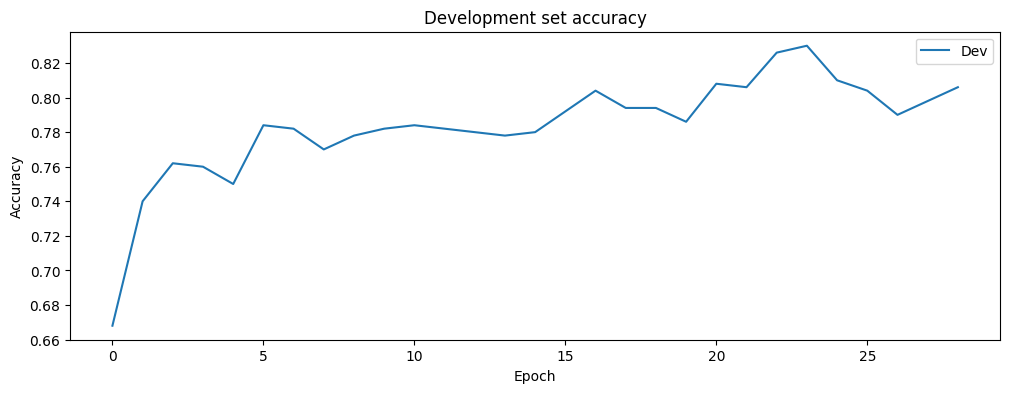

In [ ]:
# Plot train and dev accurancies and losses on training and dev data against training epochs
plt.figure(figsize=(12, 4))
plt.title('Development set accuracy')
plt.plot(range(len(dev_accuracy_list)), dev_accuracy_list, label='Dev')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

## Find optimal batch size

In [ ]:
input_dim = 300
hidden_dim = 128
output_dim = 5
batch_sizes = [2, 4, 8, 16, 24, 32, 64, 128, 256, 512]
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopper()

In [ ]:
num_epochs = 20
max_patience = 5
current_patience = 0
accuracy_list_batch_size = {}
time_taken_batch_size = {}
loss_batch_size = {}

for batch_size in batch_sizes:
  best_accuracy = 0.0
  model = BiGRU(input_dim, hidden_dim = hidden_dim, output_dim = output_dim)
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  dev_accuracy_list = []
  dev_loss_list = []
  start_time = time.time()
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=True)

  print(f"Batch size: {batch_size}")
  print("Start training...\n")
  print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
  print("-"*65)
  for epoch in range(num_epochs):
    model.train()
    start_time_epoch = time.time()
    total_training_loss = 0.0
    total_dev_loss = 0.0

    for x_batch, y_batch in train_loader:
      x_batch, y_batch = x_batch.to(device) , y_batch.to(device)
      outputs = model(x_batch.float()) # forward pass
      optimizer.zero_grad() # calculate the gradient, manually setting to 0

      # obtain the loss function
      loss = criterion(outputs.squeeze(1), y_batch)

      loss.backward() #calculates the loss of the loss function

      optimizer.step() #improve from loss, i.e backprop

      total_training_loss += loss.item()

    average_loss = total_training_loss / len(train_loader)

    # evaluate on dev set
    model.eval()
    with torch.no_grad():
      all_true_labels = []
      all_predicted_labels = []
      for inputs in dev_loader:
        x_batch, y_batch = inputs
        x_batch, y_batch = x_batch.to(device) , y_batch.to(device)
        # forward pass
        y_pred = model(x_batch.float())
        loss = criterion(y_pred.squeeze(1), y_batch)

        total_dev_loss += loss.item()

        predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

        y_batch = torch.argmax(y_batch, dim=1)

        all_true_labels.extend(y_batch.tolist())
        all_predicted_labels.extend(predicted_labels.tolist())

      average_dev_loss = total_dev_loss / len(dev_loader)
      dev_loss_list.append(average_dev_loss)



    accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
    dev_accuracy_list.append(accuracy)

    print(f"{epoch + 1:^7} | {average_loss:^12.6f} | {average_dev_loss:^10.6f} | {accuracy:^9.6f} | {(time.time() - start_time_epoch):^9.2f}")
    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_model = model.state_dict()
    # else:
    #   current_patience += 1
    #   if current_patience >= max_patience:
    #       print(f"Early stopping after {epoch} epochs.")
    #       break

  end_time = time.time()
  time_taken_batch_size[batch_size] =  end_time - start_time
  accuracy_list_batch_size[batch_size] = sum(dev_accuracy_list)/len(dev_accuracy_list)
  loss_batch_size[batch_size] = sum(dev_loss_list)/len(dev_loss_list)

  print(f"Best accuracy: {best_accuracy*100}")


Batch size: 2
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------------------------------------------------
   1    |   1.298812   |  1.203282  | 0.696000  |   7.55   
   2    |   1.171790   |  1.160931  | 0.736000  |   5.89   
   3    |   1.132712   |  1.137821  | 0.768000  |   6.47   
   4    |   1.097761   |  1.124516  | 0.778000  |   5.86   
   5    |   1.074707   |  1.116069  | 0.786000  |   6.40   
   6    |   1.053544   |  1.115087  | 0.796000  |   5.91   
   7    |   1.043157   |  1.116888  | 0.786000  |   6.40   
   8    |   1.036410   |  1.130108  | 0.772000  |   5.85   
   9    |   1.022062   |  1.113419  | 0.784000  |   6.32   
  10    |   1.011522   |  1.116483  | 0.786000  |   5.80   
  11    |   1.010979   |  1.107436  | 0.798000  |   6.37   
  12    |   0.999916   |  1.105246  | 0.796000  |   5.89   
  13    |   0.989338   |  1.112194  | 0.786000  |   6.37   
  14    |   0.988729   |  1.104776  | 0.792000  |   5.84   
 

In [ ]:
accuracy_df = pd.DataFrame(list(accuracy_list_batch_size.items()),columns = ['Batch Size','Mean Accuracy'])
accuracy_df

,Batch Size,Accuracy
0,2,0.7853
1,4,0.7903
2,8,0.7707
3,16,0.7759
4,24,0.7788
5,32,0.7691
6,64,0.7589
7,128,0.7324
8,256,0.6955
9,512,0.6520


Text(0.5, 1.0, 'Accuracy against Batch size')

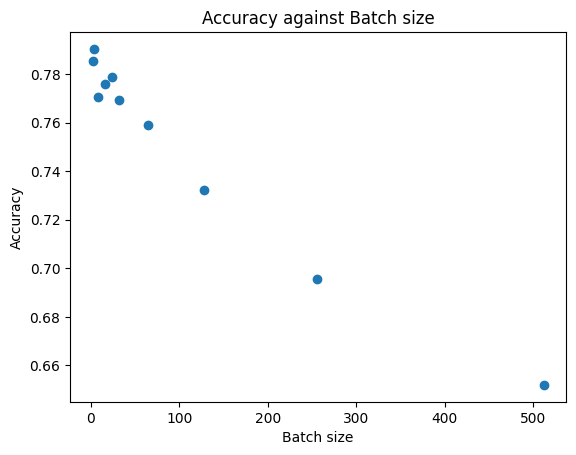

In [ ]:
# Plot dev accuracies against batch size
plt.scatter(accuracy_list_batch_size.keys(), accuracy_list_batch_size.values())
plt.xlabel("Batch size")
plt.ylabel("Mean Accuracy")
plt.title("Accuracy against Batch size")

Text(0.5, 1.0, 'Time taken against Batch size')

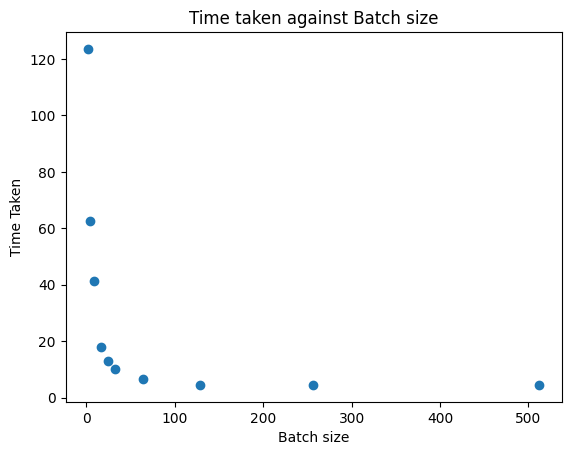

In [ ]:
# Plot dev time against batch size
plt.scatter(time_taken_batch_size.keys(), time_taken_batch_size.values())
plt.xlabel("Batch size")
plt.ylabel("Time Taken")
plt.title("Time taken against Batch size")

Batch size 24 is chosen by evaluating the accuracy and time taken for training, and it is at the elbow of the time taken graph without compromising too much accuracy.

## Find optimal number of hidden layers

In [ ]:
input_dim = 300
hidden_dim = 128
output_dim = 5
batch_size = 24
num_layers = [1, 2, 3, 4, 5, 6]
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopper()

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=True)

In [ ]:
num_epochs = 20
best_accuracy = 0.0
max_patience = 5
current_patience = 0
accuracy_list_num_layers = {}
time_taken_num_layers = {}
loss_num_layers = {}

for layer in num_layers:
  model = BiGRU(input_dim, hidden_dim = hidden_dim, output_dim = output_dim, num_layers= layer)
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  dev_accuracy_list = []
  dev_loss_list = []
  start_time = time.time()

  print(f'Number of layers: {layer}')
  print("Start training...\n")
  print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
  print("-"*65)
  for epoch in range(num_epochs):
    model.train()
    total_training_loss = 0.0
    total_dev_loss = 0.0
    start_time_epoch = time.time()
    for x_batch, y_batch in train_loader:
      x_batch, y_batch = x_batch.to(device) , y_batch.to(device)
      outputs = model(x_batch.float()) # forward pass
      optimizer.zero_grad() # calculate the gradient, manually setting to 0

      # obtain the loss function
      loss = criterion(outputs.squeeze(1), y_batch)

      loss.backward() #calculates the loss of the loss function

      optimizer.step() #improve from loss, i.e backprop

      total_training_loss += loss.item()

    average_loss = total_training_loss / len(train_loader)

    # evaluate on dev set
    model.eval()
    with torch.no_grad():
      all_true_labels = []
      all_predicted_labels = []
      for inputs in dev_loader:
        x_batch, y_batch = inputs
        x_batch, y_batch = x_batch.to(device) , y_batch.to(device)

        # forward pass
        y_pred = model(x_batch.float())
        loss = criterion(y_pred.squeeze(1), y_batch)

        total_dev_loss += loss.item()

        predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

        y_batch = torch.argmax(y_batch, dim=1)

        all_true_labels.extend(y_batch.tolist())
        all_predicted_labels.extend(predicted_labels.tolist())

      average_dev_loss = total_dev_loss / len(dev_loader)
      dev_loss_list.append(average_dev_loss)


    accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
    dev_accuracy_list.append(accuracy)

    print(f"{epoch + 1:^7} | {average_loss:^12.6f} | {average_dev_loss:^10.6f} | {accuracy:^9.6f} | {(time.time() - start_time_epoch):^9.2f}")
    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_model = model.state_dict()
    # else:
    #   current_patience += 1
    #   if current_patience >= max_patience:
    #       print(f"Early stopping after {epoch} epochs.")
    #       break

  end_time = time.time()
  time_taken_num_layers[layer] =  end_time - start_time
  accuracy_list_num_layers[layer] = sum(dev_accuracy_list)/len(dev_accuracy_list)
  loss_num_layers[layer] = sum(dev_loss_list)/len(dev_loss_list)


Number of layers: 1
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------------------------------------------------
   1    |   1.327089   |  1.175192  | 0.734000  |   1.50   
   2    |   1.167743   |  1.143059  | 0.756000  |   1.41   
   3    |   1.122934   |  1.120511  | 0.774000  |   1.41   
   4    |   1.085989   |  1.115879  | 0.776000  |   1.60   
   5    |   1.064720   |  1.124552  | 0.786000  |   2.47   
   6    |   1.047900   |  1.098631  | 0.808000  |   1.87   
   7    |   1.031912   |  1.108954  | 0.794000  |   1.72   
   8    |   1.027810   |  1.104551  | 0.790000  |   1.41   
   9    |   1.013043   |  1.132046  | 0.772000  |   1.42   
  10    |   1.007588   |  1.103735  | 0.790000  |   1.42   
  11    |   1.002686   |  1.106760  | 0.798000  |   1.51   
  12    |   0.997667   |  1.105761  | 0.806000  |   1.66   
  13    |   0.992096   |  1.101394  | 0.806000  |   1.42   
  14    |   0.990129   |  1.092672  | 0.808000  |   1.4

In [ ]:
accuracy_list_num_layers
accuracy_df = pd.DataFrame(list(accuracy_list_num_layers.items()),columns = ['Number of Layers','Mean Accuracy'])
accuracy_df

,Number of Layers,Accuracy
0,1,0.7888
1,2,0.3159
2,3,0.3371
3,4,0.3360
4,5,0.3301
5,6,0.3360


Text(0.5, 1.0, 'Accuracy against Number of Layers')

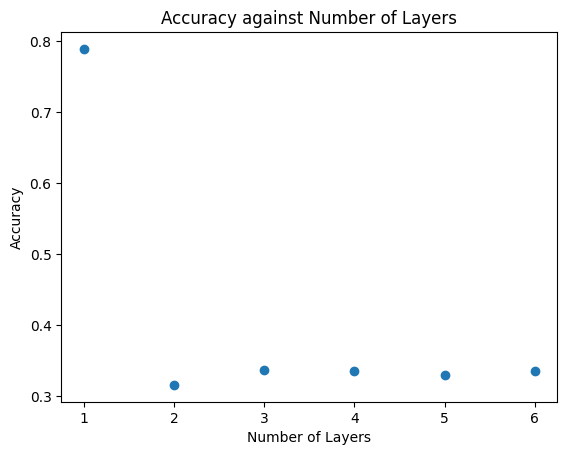

In [ ]:
# Plot dev accuracies against batch size
plt.scatter(accuracy_list_num_layers.keys(), accuracy_list_num_layers.values())
plt.xlabel("Number of Layers")
plt.ylabel("Mean Accuracy")
plt.title("Accuracy against Number of Layers")

Text(0.5, 1.0, 'Time taken against Number of Layers')

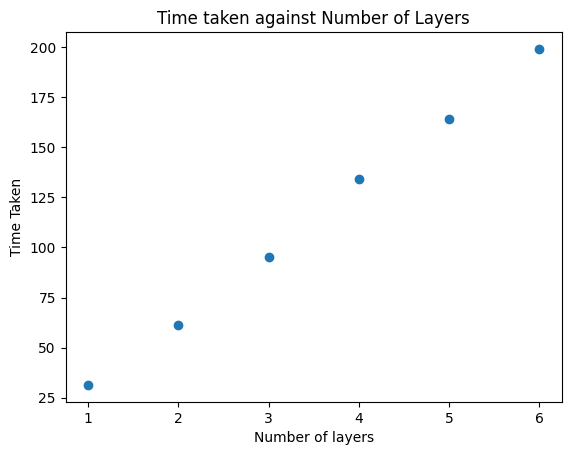

In [ ]:
# Plot dev time against batch size
plt.scatter(time_taken_num_layers.keys(), time_taken_num_layers.values())
plt.xlabel("Number of layers")
plt.ylabel("Time Taken")
plt.title("Time taken against Number of Layers")

1 is chosen for highest accuracy and shortest running time.

## Find optimal number of hidden neurons

In [ ]:
input_dim = 300
output_dim = 5
batch_size = 24
hidden_dims = [64, 128, 256, 512]
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopper()

In [ ]:
num_epochs = 20
best_accuracy = 0.0
max_patience = 5
current_patience = 0
accuracy_list_hidden_dims = {}
time_taken_hidden_dims = {}
loss_hidden_dims = {}

for hidden_dim in hidden_dims:
  model = BiGRU(input_dim, hidden_dim = hidden_dim, output_dim = output_dim)
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  dev_accuracy_list = []
  dev_loss_list = []
  start_time = time.time()

  print(f'Hidden dimension: {hidden_dim}')
  print("Start training...\n")
  print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
  print("-"*65)
  for epoch in range(num_epochs):
    model.train()
    total_training_loss = 0.0
    total_dev_loss = 0.0
    start_time_epoch = time.time()
    for x_batch, y_batch in train_loader:
      x_batch, y_batch = x_batch.to(device) , y_batch.to(device)
      outputs = model(x_batch.float()) # forward pass
      optimizer.zero_grad() # calculate the gradient, manually setting to 0

      # obtain the loss function
      loss = criterion(outputs.squeeze(1), y_batch)

      loss.backward() #calculates the loss of the loss function

      optimizer.step() #improve from loss, i.e backprop

      total_training_loss += loss.item()

    average_loss = total_training_loss / len(train_loader)

    # evaluate on dev set
    model.eval()
    with torch.no_grad():
      all_true_labels = []
      all_predicted_labels = []
      for inputs in dev_loader:
        x_batch, y_batch = inputs
        x_batch, y_batch = x_batch.to(device) , y_batch.to(device)

        # forward pass
        y_pred = model(x_batch.float())
        loss = criterion(y_pred.squeeze(1), y_batch)

        total_dev_loss += loss.item()

        predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

        y_batch = torch.argmax(y_batch, dim=1)

        all_true_labels.extend(y_batch.tolist())
        all_predicted_labels.extend(predicted_labels.tolist())

      average_dev_loss = total_dev_loss / len(dev_loader)
      dev_loss_list.append(average_dev_loss)



    accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
    dev_accuracy_list.append(accuracy)

    print(f"{epoch + 1:^7} | {average_loss:^12.6f} | {average_dev_loss:^10.6f} | {accuracy:^9.6f} | {(time.time() - start_time_epoch):^9.2f}")
    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_model = model.state_dict()
    # else:
    #   current_patience += 1
    #   if current_patience >= max_patience:
    #       print(f"Early stopping after {epoch} epochs.")
    #       break

  end_time = time.time()
  time_taken_hidden_dims[hidden_dim] =  end_time - start_time
  accuracy_list_hidden_dims[hidden_dim] = sum(dev_accuracy_list)/len(dev_accuracy_list)
  loss_hidden_dims[hidden_dim] = sum(dev_loss_list)/len(dev_loss_list)


Hidden dimension: 64
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------------------------------------------------
   1    |   1.418655   |  1.271389  | 0.650000  |   1.08   
   2    |   1.221125   |  1.182628  | 0.734000  |   1.16   
   3    |   1.158552   |  1.139929  | 0.772000  |   0.94   
   4    |   1.116658   |  1.135170  | 0.762000  |   0.87   
   5    |   1.091517   |  1.124002  | 0.770000  |   0.85   
   6    |   1.075255   |  1.133101  | 0.770000  |   0.85   
   7    |   1.055557   |  1.114502  | 0.790000  |   0.86   
   8    |   1.044769   |  1.128816  | 0.776000  |   0.87   
   9    |   1.034399   |  1.114717  | 0.790000  |   0.87   
  10    |   1.023776   |  1.124439  | 0.774000  |   0.87   
  11    |   1.020263   |  1.115314  | 0.784000  |   0.87   
  12    |   1.009149   |  1.118527  | 0.794000  |   0.87   
  13    |   1.002904   |  1.112646  | 0.790000  |   0.87   
  14    |   0.996947   |  1.103024  | 0.800000  |   0.

In [ ]:
accuracy_list_hidden_dims
accuracy_df = pd.DataFrame(list(accuracy_list_hidden_dims.items()),columns = ['Number of Hidden Dimensions','Mean Accuracy'])
accuracy_df

,Number of Hidden Dimensions,Accuracy
0,64,0.7752
1,128,0.7886
2,256,0.7784
3,512,0.7916


Text(0.5, 1.0, 'Accuracy against Number of Hidden Neurons')

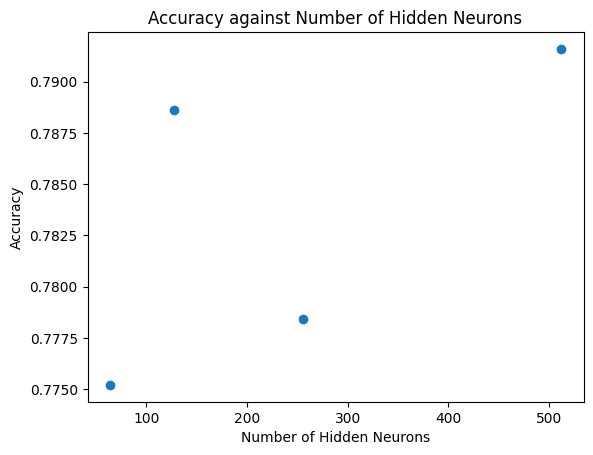

In [ ]:
# Plot dev accuracies against batch size
plt.scatter(accuracy_list_hidden_dims.keys(), accuracy_list_hidden_dims.values())
plt.xlabel("Number of Hidden Neurons")
plt.ylabel("Mean Accuracy")
plt.title("Accuracy against Number of Hidden Neurons")

Text(0.5, 1.0, 'Time taken against Number of Hidden Neurons')

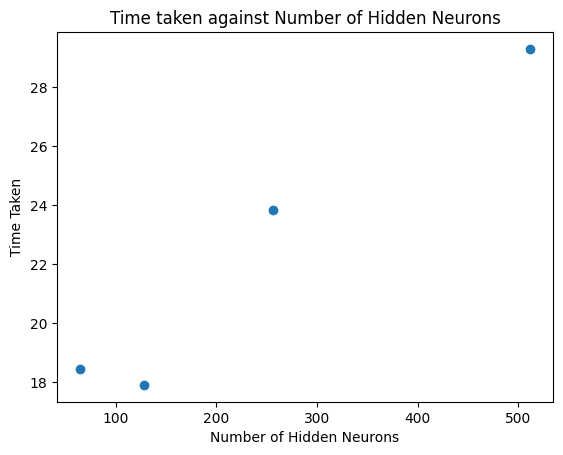

In [ ]:
# Plot dev time against batch size
plt.scatter(time_taken_hidden_dims.keys(), time_taken_hidden_dims.values())
plt.xlabel("Number of Hidden Neurons")
plt.ylabel("Time Taken")
plt.title("Time taken against Number of Hidden Neurons")

128 is chosen for higher accuracy.

## Final training


In [ ]:
input_dim = 300
hidden_dim = 128
output_dim = 5
batch_size = 24
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopper()

model = BiGRU(input_dim, hidden_dim = hidden_dim, output_dim = output_dim)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
num_epochs = 100
best_accuracy = 0.0
max_patience = 5
current_patience = 0
train_loss_list = []
train_accuracy_list = []
dev_loss_list = []
dev_accuracy_list = []
run_time = []

print("Start training...\n")
print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
print("-"*65)
for epoch in range(num_epochs):
  model.train()
  total_training_loss = 0.0
  total_dev_loss = 0.0
  start_time_epoch = time.time()

  train_true_labels = []
  train_predicted_labels = []


  for x_batch, y_batch in train_loader:
    x_batch, y_batch = x_batch.to(device) , y_batch.to(device)
    outputs = model(x_batch.float()) # forward pass
    optimizer.zero_grad() # calculate the gradient, manually setting to 0

    # obtain the loss function
    loss = criterion(outputs.squeeze(1), y_batch)

    loss.backward() #calculates the loss of the loss function

    optimizer.step() #improve from loss, i.e backprop

    total_training_loss += loss.item()

    predicted_train_labels = torch.argmax(outputs.squeeze(1), dim=1)
    y_batch = torch.argmax(y_batch, dim=1)

    train_true_labels.extend(y_batch.tolist())
    train_predicted_labels.extend(predicted_train_labels.tolist())

  average_loss = total_training_loss / len(train_loader)
  train_loss_list.append(average_loss)

  train_accuracy = calculate_accuracy(torch.tensor(train_true_labels), torch.tensor(train_predicted_labels))
  train_accuracy_list.append(train_accuracy)

  # evaluate on dev set
  model.eval()
  with torch.no_grad():
    all_true_labels = []
    all_predicted_labels = []
    for inputs in dev_loader:
      x_batch, y_batch = inputs
      x_batch, y_batch = x_batch.to(device) , y_batch.to(device)

      # forward pass
      y_pred = model(x_batch.float())
      loss = criterion(y_pred.squeeze(1), y_batch)

      total_dev_loss += loss.item()

      predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

      y_batch = torch.argmax(y_batch, dim=1)

      all_true_labels.extend(y_batch.tolist())
      all_predicted_labels.extend(predicted_labels.tolist())

    average_dev_loss = total_dev_loss / len(dev_loader)
    dev_loss_list.append(average_dev_loss)

  accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
  dev_accuracy_list.append(accuracy)

  print(f"{epoch + 1:^7} | {average_loss:^12.6f} | {average_dev_loss:^10.6f} | {accuracy:^9.6f} | {(time.time() - start_time_epoch):^9.2f}")
  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_model = model.state_dict()
    # save model
    torch.save(model.state_dict(), 'best_model.pt')

  if early_stopper.early_stop(average_dev_loss):
      print(f"Early stopping after {epoch} epochs.")
      end_time_epoch = time.time()
      time_taken = end_time_epoch - start_time_epoch
      run_time.append(time_taken)
      total_time_taken = sum(run_time)
      print(f"Time taken to run the model with optimal parameters: {total_time_taken} seconds ")
      print(f"Best accuracy: {best_accuracy}")
      break
  end_time_epoch = time.time()
  time_taken = end_time_epoch - start_time_epoch
  run_time.append(time_taken)


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------------------------------------------------
   1    |   1.382776   |  1.234234  | 0.684000  |   0.94   
   2    |   1.195751   |  1.165480  | 0.740000  |   0.90   
   3    |   1.146352   |  1.188181  | 0.732000  |   0.92   
   4    |   1.114827   |  1.129915  | 0.780000  |   0.93   
   5    |   1.088722   |  1.134466  | 0.752000  |   0.91   
   6    |   1.068787   |  1.121110  | 0.776000  |   0.90   
   7    |   1.051128   |  1.121954  | 0.776000  |   0.90   
   8    |   1.037270   |  1.122308  | 0.790000  |   0.90   
   9    |   1.027040   |  1.111148  | 0.784000  |   0.91   
  10    |   1.015220   |  1.125306  | 0.778000  |   1.01   
  11    |   1.013228   |  1.120196  | 0.780000  |   1.16   
  12    |   1.006606   |  1.116752  | 0.782000  |   1.03   
  13    |   1.001208   |  1.117771  | 0.774000  |   0.91   
  14    |   0.996646   |  1.107371  | 0.796000  |   0.92   
  15    |   0.9

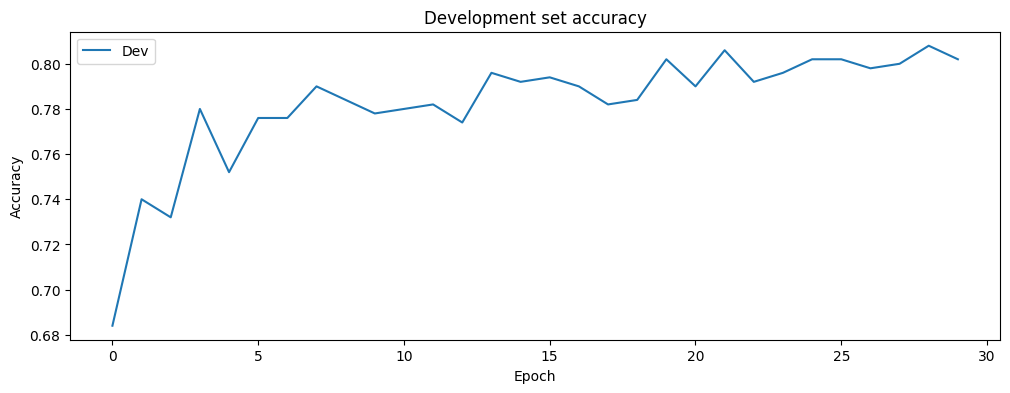

In [ ]:
# Plot train and dev accurancies and losses on training and dev data against training epochs
plt.figure(figsize=(12, 4))
plt.title('Development set accuracy')
plt.plot(range(len(dev_accuracy_list)), dev_accuracy_list, label='Dev')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

### Using test set

In [ ]:
print(x_batch, y_batch)

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 6.0303e-02,  1.1475e-01,  5.3467e-02,  ..., -4.4632e-04,
          -5.5420e-02, -3.0469e-01],
         [ 3.6133e-02,  7.4219e-02, -2.0996e-01,  ...,  4.7119e-02,
           1.0559e-02,  3.1055e-01],
         [-1.5527e-01, -1.1328e-01,  1.3379e-01,  ...,  1.0889e-01,
           1.5332e-01,  8.5449e-02]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 3.9844e-01, -4

In [ ]:
model.load_state_dict(best_model)
model.eval()
with torch.no_grad():
  all_true_labels = []
  all_predicted_labels = []
  total_test_loss = 0

  test_loader = DataLoader(test_data, shuffle=True)

  for X, y in test_loader:
    X, y = X.to(device), y.to(device)
    # forward pass
    y_pred = model(X.float())
    loss = criterion(y_pred.squeeze(1), y)

    total_test_loss += loss.item()

    predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

    y_batch = torch.argmax(y, dim=1)

    all_true_labels.extend(y_batch.tolist())
    all_predicted_labels.extend(predicted_labels.tolist())

  average_test_loss = total_test_loss/len(test_loader)
  print(f"Average loss: {average_test_loss}")

accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
print(f"Accuracy: {accuracy * 100:.2f}%")

Average loss: 1.0929251936674118
Accuracy: 80.80%


In [ ]:
result_df = pd.DataFrame({"train_loss":train_loss_list,
                "train_accuracy":train_accuracy_list,
                "dev_loss":dev_loss_list,
                "dev_accuracy":dev_accuracy_list,
                "epoch_time":time_taken})
display(result_df)


,train_loss,train_accuracy,dev_loss,dev_accuracy,epoch_time
0,1.382776,0.531502,1.234234,0.684,0.926016
1,1.195751,0.713449,1.165480,0.740,0.926016
2,1.146352,0.763530,1.188181,0.732,0.926016
3,1.114827,0.798061,1.129915,0.780,0.926016
4,1.088722,0.822294,1.134466,0.752,0.926016
5,1.068787,0.842892,1.121110,0.776,0.926016
6,1.051128,0.859855,1.121954,0.776,0.926016
7,1.037270,0.873788,1.122308,0.790,0.926016
8,1.027040,0.883078,1.111148,0.784,0.926016
9,1.015220,0.893174,1.125306,0.778,0.926016


In [12]:
# model layers summary
from torchinfo import summary
input_dim = 300
hidden_dim = 128
output_dim = 5
batch_size = 24
MAX_LENGTH = 18
model = BiGRU(input_dim, hidden_dim, output_dim)
print(summary(model, (1, MAX_LENGTH, 300), device="cpu"))

print("GRU Layer")
for key, weights in model.rnn.state_dict().items():
    print(f"{key}: {weights.shape}")
print()
print("Linear Layer")
for key, weights in model.head.state_dict().items():
    print(f"{key}: {weights.shape}")

Layer (type:depth-idx)                   Output Shape              Param #
BiGRU                                    [1, 1, 5]                 --
├─GRU: 1-1                               [1, 18, 256]              330,240
├─Sequential: 1-2                        [1, 1, 5]                 --
│    └─Linear: 2-1                       [1, 1, 5]                 1,285
│    └─Softmax: 2-2                      [1, 1, 5]                 --
Total params: 331,525
Trainable params: 331,525
Non-trainable params: 0
Total mult-adds (M): 5.95
Input size (MB): 0.02
Forward/backward pass size (MB): 0.04
Params size (MB): 1.33
Estimated Total Size (MB): 1.38
GRU Layer
weight_ih_l0: torch.Size([384, 300])
weight_hh_l0: torch.Size([384, 128])
bias_ih_l0: torch.Size([384])
bias_hh_l0: torch.Size([384])
weight_ih_l0_reverse: torch.Size([384, 300])
weight_hh_l0_reverse: torch.Size([384, 128])
bias_ih_l0_reverse: torch.Size([384])
bias_hh_l0_reverse: torch.Size([384])

Linear Layer
0.weight: torch.Size([5, 256])